In [1]:
# Import packages
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load
from sklearn.metrics import r2_score
import shap
from sklearn.inspection import PartialDependenceDisplay

C:\Users\Holger\micromamba\envs\agile2024\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set_theme()

# Prepare RF training and test sets

In [3]:
# Read ML input
ml_input = pd.read_csv("agile2024_tn_ml_input.csv", sep=",")
display(ml_input)

,obs_id,site_code,obs_year,obs_value,arable_prop,area,clay1_mean,forest_prop,grassland_prop,k1_mean,...,rock1_mean,sand1_mean,silt1_mean,slope_mean,soc1_mean,temp_mean,twi_mean,urban_prop,water_prop,wetland_prop
0,1,SJA0088000,2016,1.138,0.122,704297025.0,21.031,0.706,0.035,59.083,...,4.072,65.292,13.677,0.875,8.971,6.524,9.851,0.012,0.004,0.084
1,2,SJA0088000,2017,1.175,0.122,704297025.0,21.031,0.706,0.035,59.083,...,4.072,65.292,13.677,0.875,8.971,6.495,9.851,0.012,0.004,0.084
2,3,SJA0106000,2016,5.967,0.428,26553800.0,25.857,0.491,0.025,16.544,...,5.801,55.326,18.817,0.813,8.528,6.231,10.252,0.018,0.000,0.021
3,4,SJA0106000,2017,4.175,0.428,26553800.0,25.857,0.491,0.025,16.544,...,5.801,55.326,18.817,0.813,8.528,6.133,10.252,0.018,0.000,0.021
4,5,SJA0106000,2018,4.225,0.428,26553800.0,25.857,0.491,0.025,16.544,...,5.801,55.326,18.817,0.813,8.528,7.025,10.252,0.018,0.000,0.021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,461,SJB3502000,2019,5.347,0.579,18557575.0,25.775,0.322,0.032,40.267,...,8.719,57.976,16.249,0.924,8.993,6.842,10.334,0.023,0.003,0.025
461,462,SJB3502000,2020,5.596,0.579,18557575.0,25.775,0.322,0.032,40.267,...,8.719,57.976,16.249,0.924,8.993,7.783,10.334,0.023,0.003,0.025
462,463,SJB3503000,2020,8.225,0.537,112294125.0,22.755,0.304,0.083,14.110,...,9.007,55.590,21.654,1.292,7.390,7.684,10.033,0.028,0.002,0.014
463,464,SJB3510000,2019,8.090,0.475,29300575.0,21.450,0.303,0.082,24.142,...,8.858,59.238,19.312,1.822,8.315,6.743,9.690,0.025,0.004,0.096


In [4]:
ml_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465 entries, 0 to 464
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   obs_id             465 non-null    int64  
 1   site_code          465 non-null    object 
 2   obs_year           465 non-null    int64  
 3   obs_value          465 non-null    float64
 4   arable_prop        465 non-null    float64
 5   area               465 non-null    float64
 6   clay1_mean         465 non-null    float64
 7   forest_prop        465 non-null    float64
 8   grassland_prop     465 non-null    float64
 9   k1_mean            465 non-null    float64
 10  limestone_prop     465 non-null    float64
 11  livestock_density  465 non-null    float64
 12  other_prop         465 non-null    float64
 13  precip_mean        465 non-null    float64
 14  rock1_mean         465 non-null    float64
 15  sand1_mean         465 non-null    float64
 16  silt1_mean         465 non

In [5]:
ml_input[ml_input["temp_mean"].isna()]

,obs_id,site_code,obs_year,obs_value,arable_prop,area,clay1_mean,forest_prop,grassland_prop,k1_mean,...,rock1_mean,sand1_mean,silt1_mean,slope_mean,soc1_mean,temp_mean,twi_mean,urban_prop,water_prop,wetland_prop


C:\Users\Holger\AppData\Local\Temp\ipykernel_26132\814460452.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  ml_input.iloc[:, 4:].hist(ax=ax)


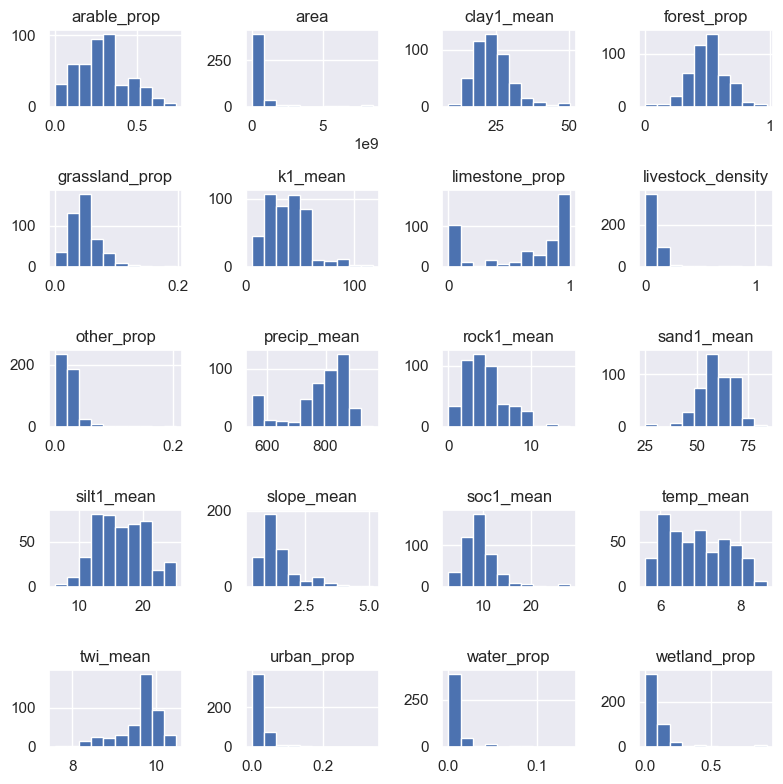

In [6]:
# Plot histograms of features
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()
ml_input.iloc[:, 4:].hist(ax=ax)
fig.tight_layout()

In [7]:
# Extract features and target
X = ml_input.iloc[:, 4:]
y = ml_input["obs_value"]

In [8]:
# Split the data into training and test sets
test_size = 0.3
random_state = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# Hyperparameter tuning

In [9]:
# Number of trees in random forest
n_estimators = list(np.linspace(start=10, stop=100, num=10, dtype=int))

# Number of features to consider at every split
max_features = [1, "sqrt", "log2"]

# Maximum number of levels in tree
max_depth = list(np.linspace(start=10, stop=100, num=10, dtype=int))
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create dictionary from parameters
param_distributions = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap
}

In [10]:
%%time

# Perform search for hyperparameters
estimator = RandomForestRegressor()
rf_random = RandomizedSearchCV(
    estimator=estimator, param_distributions=param_distributions, n_iter=100, verbose=2, random_state=random_state,
    n_jobs=-1
)
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 3.02 s
Wall time: 36 s


RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': [1, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=1, verbose=2)

In [11]:
# Get best parameters
params = rf_random.best_params_
params["bootstrap"] = True
params["oob_score"] = True

print(rf_random)
print(params)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': [1, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=1, verbose=2)
{'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True, 'oob_score': True}


# Train model

In [12]:
# RF regressor
regressor = RandomForestRegressor()

In [13]:
# Set hyperparameters
regressor.set_params(**params)

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=30, oob_score=True)

In [14]:
# Fit model
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=2,
                      n_estimators=30, oob_score=True)

In [15]:
# Calculate accuracy on training set
regressor.score(X_train, y_train)

0.9313886782860312

In [16]:
# Predict
Y_train_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)

In [17]:
# Calculate accuracy on test set
r2_score(y_test, Y_test_pred)

0.8067824626167726

# Calculate SHAP values

In [18]:
# Calculate SHAP values
explainer = shap.TreeExplainer(regressor)
shap_values = shap.TreeExplainer(regressor).shap_values(X_train)

In [19]:
shap_values

array([[-1.55040744e-01,  1.55083468e-02,  1.62769298e-02, ...,
         3.16195485e-02, -8.28098893e-02, -2.49516095e-02],
       [ 1.61752613e+00, -1.23036121e-03,  8.42579346e-02, ...,
         1.12636790e-01,  2.66209708e-01,  1.96080170e-01],
       [ 1.43126822e+00,  1.26158676e-01, -4.62317715e-03, ...,
         1.56379232e-01,  1.57567680e-01,  8.49981105e-02],
       ...,
       [-1.08415046e-01, -1.54465296e-02, -2.22530596e-02, ...,
         3.97616024e-02, -8.31175780e-02, -3.62178354e-02],
       [-3.98442509e-02, -1.32038189e-02,  2.05805785e-02, ...,
         6.22474754e-02, -5.50913473e-02, -1.92889062e-02],
       [-5.13100077e-01,  1.24301293e-02,  3.29592180e-02, ...,
         3.29604802e-02, -6.57473634e-03, -1.87333273e-02]])

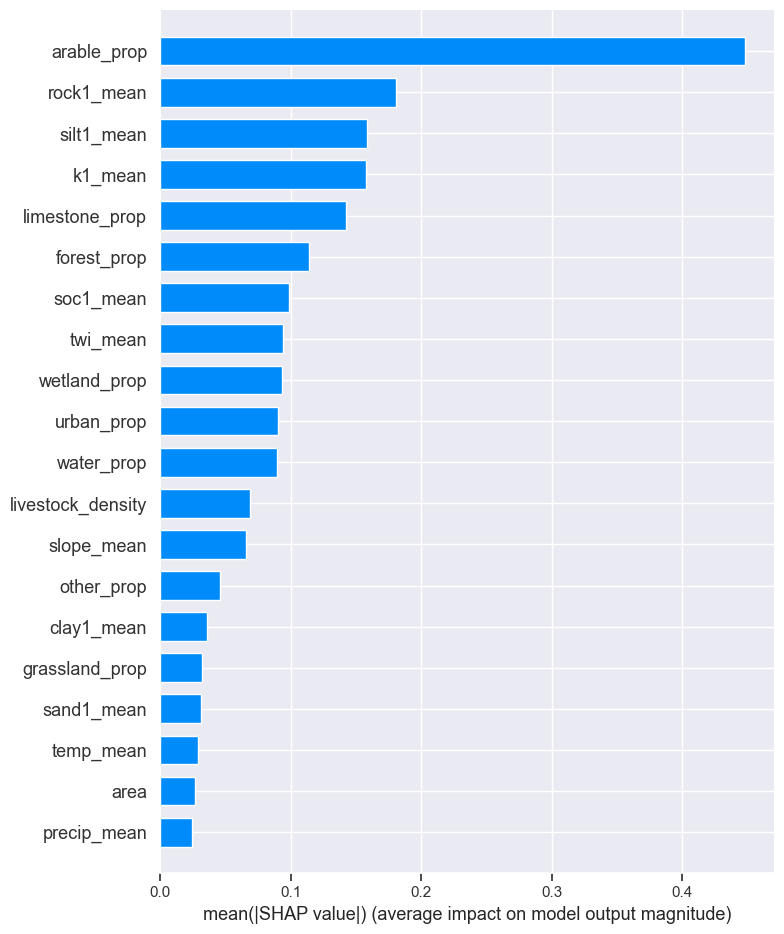

<Figure size 640x480 with 0 Axes>

In [20]:
# SHAP summary bar plot
shap.summary_plot(shap_values=shap_values, features=X_train, feature_names=X_train.columns, plot_type="bar")
plt.tight_layout()

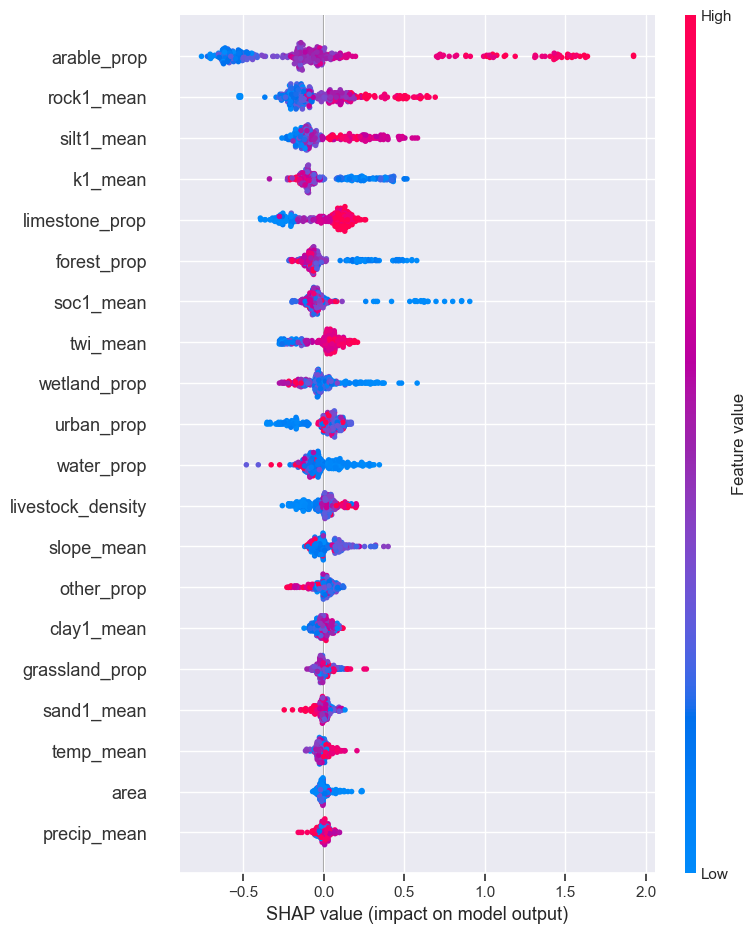

<Figure size 640x480 with 0 Axes>

In [21]:
# SHAP summary beeswarm plot
shap.summary_plot(shap_values=shap_values, features=X_train, feature_names=X_train.columns)
plt.tight_layout()

# Reduce number of features based on SHAP values

In [22]:
# Create DataFrame of absolute mean SHAP values
abs_mean_shap_df = pd.DataFrame(
    list(zip(X_test.columns, np.abs(shap_values).mean(0))), columns=["feature", "abs_mean_shap"]
)

In [23]:
# Sort based on absolute mean SHAP values
abs_mean_shap_df = abs_mean_shap_df.sort_values(by=["abs_mean_shap"], ascending=False).reset_index(drop=True)

In [24]:
abs_mean_shap_df

,feature,abs_mean_shap
0,arable_prop,0.448030
1,rock1_mean,0.180658
2,silt1_mean,0.158187
3,k1_mean,0.157649
4,limestone_prop,0.142513
5,forest_prop,0.113657
6,soc1_mean,0.098475
7,twi_mean,0.093773
8,wetland_prop,0.093175
9,urban_prop,0.090508


In [25]:
# List of most important features
n_features = 15
top_features = abs_mean_shap_df["feature"].head(n_features).to_list()
print(top_features)

['arable_prop', 'rock1_mean', 'silt1_mean', 'k1_mean', 'limestone_prop', 'forest_prop', 'soc1_mean', 'twi_mean', 'wetland_prop', 'urban_prop', 'water_prop', 'livestock_density', 'slope_mean', 'other_prop', 'clay1_mean']


In [26]:
# Generate new training and test feature sets
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]

# Train model on reduced data

In [27]:
%%time

# Perform search for hyperparameters
estimator = RandomForestRegressor()
rf_random = RandomizedSearchCV(
    estimator=estimator, param_distributions=param_distributions, n_iter=100, verbose=2, random_state=random_state,
    n_jobs=-1
)
rf_random.fit(X_train_reduced, y_train)

# Get best parameters
params = rf_random.best_params_
params["bootstrap"] = True
params["oob_score"] = True

print(rf_random)
print(params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': [1, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=1, verbose=2)
{'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 60, 'bootstrap': True, 'oob_score': True}
CPU times: total: 2.59 s
Wall time: 24.2 s


In [28]:
# RF regressor
regressor_reduced = RandomForestRegressor()

# Set hyperparameters
regressor_reduced.set_params(**params)

# Fit model
regressor_reduced.fit(X_train_reduced, y_train)

C:\Users\Holger\micromamba\envs\agile2024\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(max_depth=60, max_features='log2', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=20, oob_score=True)

In [29]:
# Calculate accuracy on training set
regressor_reduced.score(X_train_reduced, y_train)

0.917369678657187

In [30]:
# Predict
Y_train_pred_reduced = regressor_reduced.predict(X_train_reduced)
Y_test_pred_reduced = regressor_reduced.predict(X_test_reduced)

In [31]:
# Calculate accuracy on test set
r2_score(y_test, Y_test_pred_reduced)

0.7897965344787582

# SHAP analysis of the new model

In [32]:
# Calculate SHAP values
explainer_reduced = shap.TreeExplainer(regressor_reduced)
shap_values_reduced = shap.TreeExplainer(regressor_reduced).shap_values(X_train_reduced)

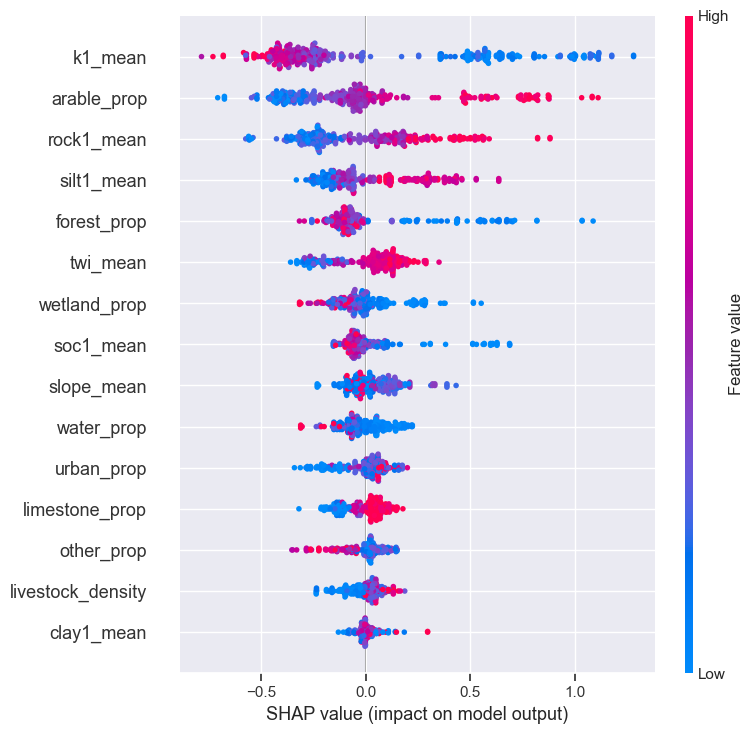

<Figure size 640x480 with 0 Axes>

In [33]:
# SHAP summary beeswarm plot
shap.summary_plot(shap_values=shap_values_reduced, features=X_train_reduced, feature_names=X_train_reduced.columns)
plt.tight_layout()

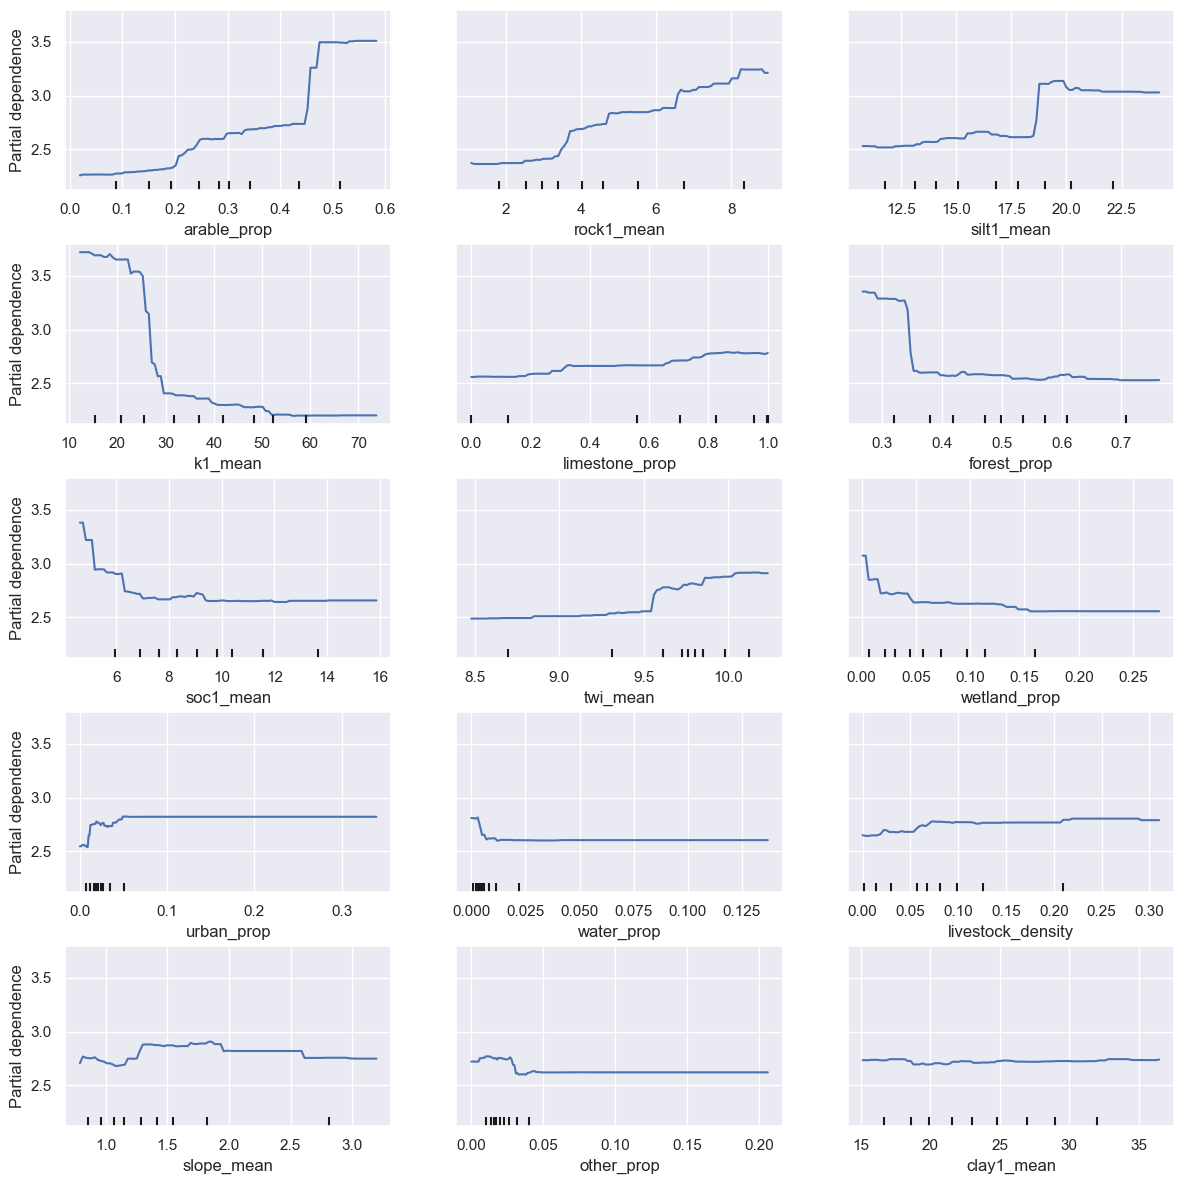

In [34]:
# Create partial dependence plot
fig, ax = plt.subplots(figsize=(12, 12))
disp = PartialDependenceDisplay.from_estimator(regressor_reduced, X_train_reduced, X_train_reduced.columns, ax=ax)
fig.subplots_adjust(hspace=0.3)
fig.tight_layout()